# Deep backward schemes for high-dimensional nonlinear PDEs

In [1]:
%pip install -e ..

Obtaining file:///Users/ryan/Developer/Projects/dbdp
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for dbdp (pyproject.toml) ... done
  Created wheel for dbdp: filename=dbdp-0.1-0.editable-py3-none-any.whl size=2579 sha256=7c8bce29df12160281b0f41cf97f107346026ef7ce7e1b327b68e81caec7d469
  Stored in directory: /private/var/folders/p4/mbr166wd3zq78yjs07dgt9bc0000gn/T/pip-ephem-wheel-cache-dc10xz9z/wheels/28/28/14/5bf41b8af05a6d32ee13f909b4f2ba39f60ef95ce12f2405f9
Successfully built dbdp
  Attempting uninstall: dbdp
    Found existing installation: dbdp 0.1
    Uninstalling dbdp-0.1:
      Successfully uninstalled dbdp-0.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from dbdp import *

import torch
import numpy as np
import matplotlib.pyplot as plt

## Example 1:

$$
    \mu=0.2,\ \sigma=1.0,\ T=2.0,\ x_0=1.0
$$

$$
    g(x)=\cos(x)
$$

$$
    f(t,x,y,z)=(\cos(x)(e^{(T-t)/2}+\sigma^2/2)+\mu\sin(x))e^{(T-t)/2}-\frac{1}{2}(\sin(x)\cos(x)e^{T-t})^2+\frac{1}{2}(yz)^2
$$

In [10]:
mu = 0.2
sigma = 1.0

drift = lambda t, x: mu
diffusion = lambda t, x: sigma

sde = SDE(drift, diffusion, 1)
euler = EulerScheme(sde)

maturity = 2.0
time_steps = 240
dt = maturity / time_steps

sample_count = 5_000

x = torch.tensor(1.0)


def f(t, x, y, z):
    a = torch.cos(x) * (np.exp((maturity - t) / 2) + sigma**2 / 2) + mu * torch.sin(x)
    b = -((torch.sin(x) * torch.cos(x) * np.exp(maturity - t)) ** 2) + (y * z) ** 2
    return a * np.exp((maturity - t) / 2) + b / 2


def g(x):
    return torch.cos(x)

In [4]:
dbdg1 = DBDP1(f, g, maturity, time_steps, 1)
dbdg1.load("../models/example-01.pt")

Model loaded from ../models/example-01.pt


In [11]:
# Generating datas
dw = np.sqrt(dt) * torch.randn((sample_count, time_steps))
paths = euler.build_path(x, dt, dw)

trains_losses, tests_losses = dbdg1.train(paths, dw, 100, batch_size=1024)
dbdg1.save("../models/example-01.pt")

Training: 100%|██████████| 240/240 [13:15<00:00,  3.32s/it]

Model saved to ../models/example-01.pt


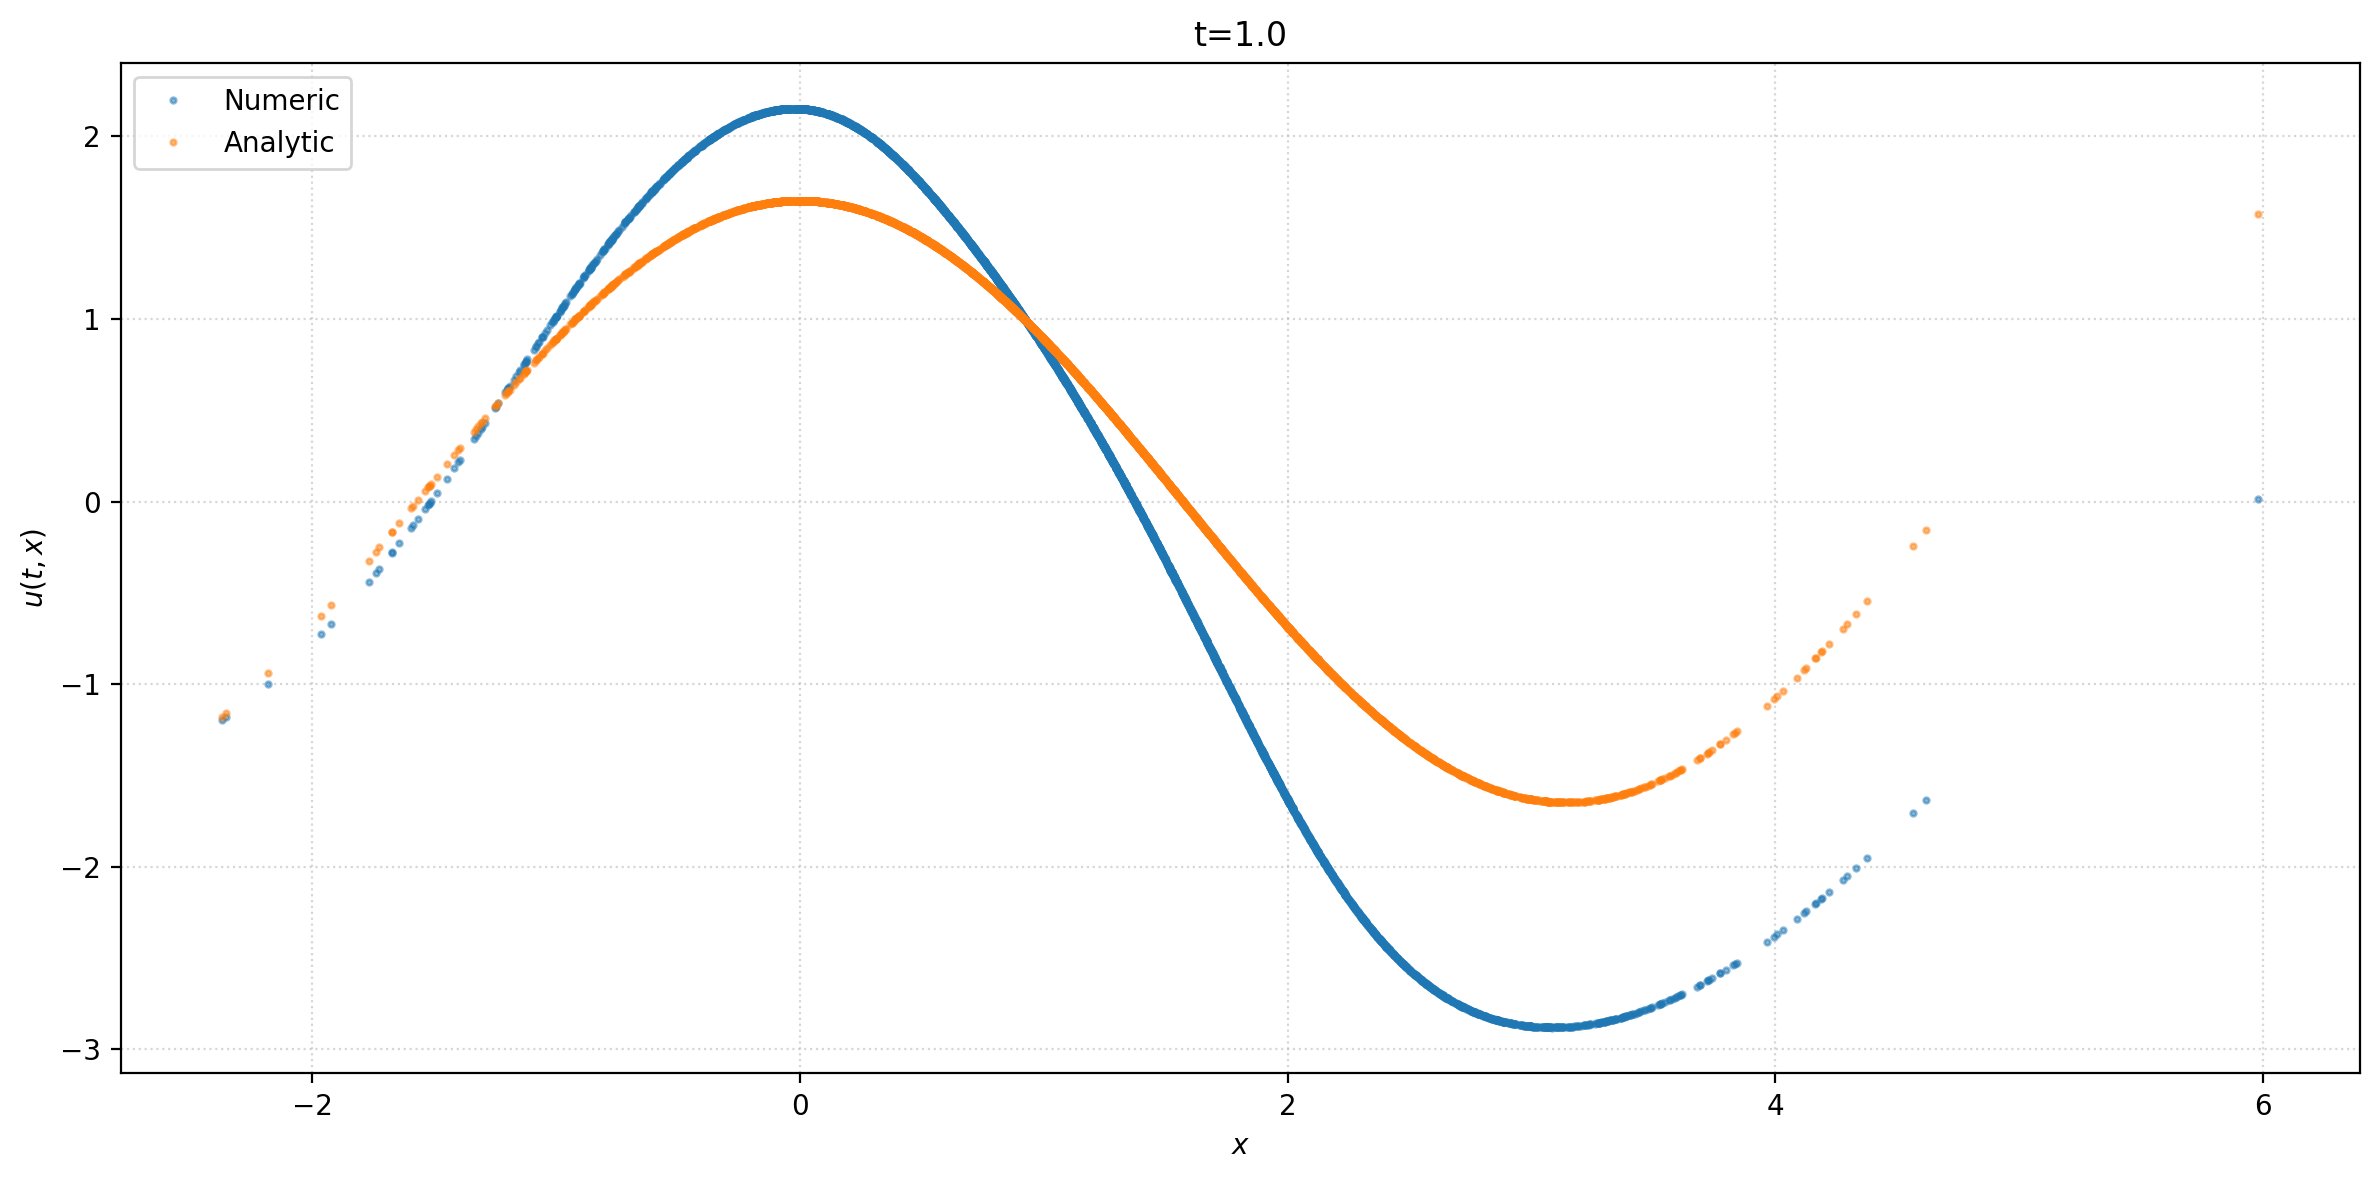

In [12]:
time = np.linspace(0, maturity, time_steps + 1)
i = 120
t = time[i]
x = paths[:, i].unsqueeze(1)
u_approx = dbdg1(t - dt, x).detach()

plt.figure(figsize=(12, 6), dpi=200)
plt.title(f"t={t}")
plt.plot(x, u_approx, ".", markersize=4, label="Numeric", alpha=0.5)
plt.plot(x, np.exp((maturity - t) / 2) * torch.cos(x), ".", markersize=4, label="Analytic", alpha=0.5)
plt.grid(alpha=0.5, ls="dotted")
plt.xlabel("$x$")
plt.ylabel("$u(t,x)$")
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()